## imports

In [8]:
import torch
import yaml
from src.utils.my_logger import get_colorlogger
from src.utils.logging import AverageMeter, CSVLogger, get_logger, gpu_timer
import os

## Logger

In [9]:
logger = get_colorlogger(name="train-droid")

## Loading configuration

In [10]:
config_fname = "mydroiddata/droid-256px-8f.yaml"

with open(config_fname, "r") as y_file:
        args = yaml.load(y_file, Loader=yaml.FullLoader)
        logger.info("loaded params...")

INFO     2026-01-05 10:29:57 train-droid 1880302584.py:5 loaded params...


In [11]:
_GLOBAL_SEED = 0

In [12]:
# -- META
folder = args.get("folder")
cfgs_meta = args.get("meta")
r_file = cfgs_meta.get("resume_checkpoint", None)
p_file = cfgs_meta.get("pretrain_checkpoint", None)
load_predictor = cfgs_meta.get("load_predictor", False)
context_encoder_key = cfgs_meta.get("context_encoder_key", "encoder")
target_encoder_key = cfgs_meta.get("target_encoder_key", "target_encoder")
load_encoder = cfgs_meta.get("load_encoder", True)
seed = cfgs_meta.get("seed", _GLOBAL_SEED)
save_every_freq = cfgs_meta.get("save_every_freq", -1)
skip_batches = cfgs_meta.get("skip_batches", -1)
use_sdpa = cfgs_meta.get("use_sdpa", False)
sync_gc = cfgs_meta.get("sync_gc", False)
which_dtype = cfgs_meta.get("dtype")
logger.info(f"{which_dtype=}")
if which_dtype.lower() == "bfloat16":
    dtype = torch.bfloat16
    mixed_precision = True
elif which_dtype.lower() == "float16":
    dtype = torch.float16
    mixed_precision = True
else:
    dtype = torch.float32
    mixed_precision = False

# -- MODEL
cfgs_model = args.get("model")
compile_model = cfgs_model.get("compile_model", False)
use_activation_checkpointing = cfgs_model.get("use_activation_checkpointing", False)
model_name = cfgs_model.get("model_name")
pred_depth = cfgs_model.get("pred_depth")
pred_num_heads = cfgs_model.get("pred_num_heads", None)
pred_embed_dim = cfgs_model.get("pred_embed_dim")
pred_is_frame_causal = cfgs_model.get("pred_is_frame_causal", True)
uniform_power = cfgs_model.get("uniform_power", False)
use_rope = cfgs_model.get("use_rope", False)
use_silu = cfgs_model.get("use_silu", False)
use_pred_silu = cfgs_model.get("use_pred_silu", False)
wide_silu = cfgs_model.get("wide_silu", True)
use_extrinsics = cfgs_model.get("use_extrinsics", False)

# -- DATA
cfgs_data = args.get("data")
datasets = cfgs_data.get("datasets", [])
dataset_path = datasets[0]
dataset_fpcs = cfgs_data.get("dataset_fpcs")
max_num_frames = max(dataset_fpcs)
camera_frame = cfgs_data.get("camera_frame", False)
camera_views = cfgs_data.get("camera_views", ["left_mp4_path"])
stereo_view = cfgs_data.get("stereo_view", False)
batch_size = cfgs_data.get("batch_size")
tubelet_size = cfgs_data.get("tubelet_size")
fps = cfgs_data.get("fps")
crop_size = cfgs_data.get("crop_size", 256)
patch_size = cfgs_data.get("patch_size")
pin_mem = cfgs_data.get("pin_mem", False)
num_workers = cfgs_data.get("num_workers", 1)
persistent_workers = cfgs_data.get("persistent_workers", True)

# -- DATA AUGS
cfgs_data_aug = args.get("data_aug")
horizontal_flip = cfgs_data_aug.get("horizontal_flip", False)
ar_range = cfgs_data_aug.get("random_resize_aspect_ratio", [3 / 4, 4 / 3])
rr_scale = cfgs_data_aug.get("random_resize_scale", [0.3, 1.0])
motion_shift = cfgs_data_aug.get("motion_shift", False)
reprob = cfgs_data_aug.get("reprob", 0.0)
use_aa = cfgs_data_aug.get("auto_augment", False)

# -- LOSS
cfgs_loss = args.get("loss")
loss_exp = cfgs_loss.get("loss_exp")
normalize_reps = cfgs_loss.get("normalize_reps")
auto_steps = min(cfgs_loss.get("auto_steps", 1), max_num_frames)
# --
tokens_per_frame = int((crop_size // patch_size) ** 2)

# -- OPTIMIZATION
cfgs_opt = args.get("optimization")
ipe = cfgs_opt.get("ipe", None)
wd = float(cfgs_opt.get("weight_decay"))
final_wd = float(cfgs_opt.get("final_weight_decay"))
num_epochs = cfgs_opt.get("epochs")
anneal = cfgs_opt.get("anneal")
warmup = cfgs_opt.get("warmup")
start_lr = cfgs_opt.get("start_lr")
lr = cfgs_opt.get("lr")
final_lr = cfgs_opt.get("final_lr")
enc_lr_scale = cfgs_opt.get("enc_lr_scale", 1.0)
betas = cfgs_opt.get("betas", (0.9, 0.999))
eps = cfgs_opt.get("eps", 1.0e-8)
# ----------------------------------------------------------------------- #
# ----------------------------------------------------------------------- #


INFO     2026-01-05 10:29:57 train-droid 1516709990.py:16 which_dtype='bfloat16'


## Setting Vars

In [13]:
# Load apple gpu
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
    logger.info("Using Apple GPU")

INFO     2026-01-05 10:29:58 train-droid 3734729410.py:5 Using Apple GPU


In [14]:
world_size, rank = 1, 0

In [15]:
 # -- log/checkpointing paths
log_file = os.path.join(folder, f"log_r{rank}.csv")
latest_path = os.path.join(folder, "latest.pt")
resume_path = os.path.join(folder, r_file) if r_file is not None else latest_path
if not os.path.exists(resume_path):
    resume_path = None

In [16]:
# -- make csv_logger
csv_logger = CSVLogger(
    log_file,
    ("%d", "epoch"),
    ("%d", "itr"),
    ("%.5f", "loss"),
    ("%d", "iter-time(ms)"),
    ("%d", "gpu-time(ms)"),
    ("%d", "dataload-time(ms)"),
    mode="+a",
)

In [17]:
# Print the vars
for k, v in args.items():
    if isinstance(v, dict):
        print(f"{k}:")
        for k1, v1 in v.items():
            print(f"    {k1}: {v1}")
    else:
        print(f"{k}: {v}")

print("log_file:", log_file)
print("latest_path:", latest_path)
print("resume_path:", resume_path)

app: vjepa_droid
cpus_per_task: 4
folder: mydroiddata/droid-256px-8f
mem_per_gpu: 22G
nodes: 1
tasks_per_node: 1
data:
    batch_size: 1
    camera_views: ['left_mp4_path']
    crop_size: 224
    datasets: ['mydroiddata/dataset/droid_raw/droid_index.csv']
    dataset_fpcs: [8]
    fps: 3
    num_workers: 0
    patch_size: 16
    pin_mem: True
    stereo_view: False
    tubelet_size: 2
data_aug:
    auto_augment: False
    horizontal_flip: False
    motion_shift: False
    random_resize_aspect_ratio: [0.85, 1.15]
    random_resize_scale: [0.8, 1.0]
    reprob: 0.0
loss:
    auto_steps: 2
    loss_exp: 1.0
    normalize_reps: True
    reg_coeff: 0.0
meta:
    dtype: bfloat16
    eval_freq: 50
    resume_checkpoint: None
    load_predictor: False
    pretrain_checkpoint: mydroiddata/droid-256px-8f/checkpoints/vitl.pt
    context_encoder_key: target_encoder
    target_encoder_key: target_encoder
    save_every_freq: 10
    seed: 239
    use_sdpa: True
model:
    model_name: vit_large
    p

# Loading the model

In [18]:
from app.vjepa_droid.utils import (
    init_opt, 
    init_video_model, 
    load_checkpoint, 
    load_pretrained
)

In [19]:
import copy

In [20]:
model_name="vit_large"

In [21]:
# -- init model
encoder, predictor = init_video_model(
    uniform_power=uniform_power,
    device=device,
    patch_size=patch_size,
    max_num_frames=512,
    tubelet_size=tubelet_size,
    model_name=model_name,
    crop_size=crop_size,
    pred_depth=pred_depth,
    pred_num_heads=pred_num_heads,
    pred_embed_dim=pred_embed_dim,
    action_embed_dim=7,
    pred_is_frame_causal=pred_is_frame_causal,
    use_extrinsics=use_extrinsics,
    use_sdpa=use_sdpa,
    use_silu=use_silu,
    use_pred_silu=use_pred_silu,
    wide_silu=wide_silu,
    use_rope=use_rope,
    use_activation_checkpointing=use_activation_checkpointing,
)
target_encoder = copy.deepcopy(encoder)

INFO     2026-01-05 10:30:11 train-droid utils.py:190 VisionTransformer(
  (patch_embed): PatchEmbed3D(
    (proj): Conv3d(3, 1024, kernel_size=(2, 16, 16), stride=(2, 16, 16))
  )
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): RoPEAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=

In [22]:
151968128/303885312

0.5000838210962957

In [23]:
if compile_model:
        logger.info("Compiling encoder, target_encoder, and predictor.")
        torch._dynamo.config.optimize_ddp = False
        encoder.compile()
        target_encoder.compile()
        predictor.compile()

In [24]:
# !curl -L \
#   https://dl.fbaipublicfiles.com/vjepa2/vitl.pt \
#   -o mydroiddata/droid-256px-8f/checkpoints/vitl.pt


In [25]:
# -- looad pretrained weights
encoder, predictor, target_encoder = load_pretrained(
    r_path=p_file,
    encoder=encoder,
    predictor=predictor,
    context_encoder_key=context_encoder_key,
    target_encoder_key=target_encoder_key,
    target_encoder=target_encoder,
    load_predictor=load_predictor,
    load_encoder=load_encoder,
)

INFO     2026-01-05 10:30:11 train-droid utils.py:35 Loading pretrained model from mydroiddata/droid-256px-8f/checkpoints/vitl.pt
INFO     2026-01-05 10:30:11 checkpoint-loader checkpoint_loader.py:30 Loading checkpoint from mydroiddata/droid-256px-8f/checkpoints/vitl.pt, attempt 1/3
INFO     2026-01-05 10:30:14 train-droid utils.py:47 loaded pretrained encoder from epoch 40 with msg: <All keys matched successfully>
INFO     2026-01-05 10:30:14 train-droid utils.py:63 loaded pretrained target encoder from epoch 40 with msg: <All keys matched successfully>


['encoder', 'predictor', 'opt', 'scaler', 'target_encoder', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']


In [26]:
p_file

'mydroiddata/droid-256px-8f/checkpoints/vitl.pt'

In [27]:
for p in target_encoder.parameters():
        p.requires_grad = False

In [28]:
from src.utils.checkpoint_loader import robust_checkpoint_loader
checkpoint = robust_checkpoint_loader(p_file, map_location=torch.device("cpu"))

INFO     2026-01-05 10:30:14 checkpoint-loader checkpoint_loader.py:30 Loading checkpoint from mydroiddata/droid-256px-8f/checkpoints/vitl.pt, attempt 1/3


In [29]:
pretrained_dict = checkpoint[context_encoder_key]
pretrained_dict_ = {k.replace("module.backbone.", ""): v for k, v in pretrained_dict.items()}

In [30]:
encoder.load_state_dict(pretrained_dict, strict=False)

_IncompatibleKeys(missing_keys=['patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc1.bias', 'blocks.2.mlp.fc2.weight', 'blocks.2.m

## Downloading the dataset

In [31]:
#### # Example 100 episodes from the DROID dataset in RLDS for debugging (2GB)
#### !gsutil -m cp -r gs://gresearch/robotics/droid_100 mydroiddata/droid-256px-8f/dataset/

In [32]:
## Downloading Gupta Lab data from the full dataset
# !sh copy-droid-data.sh

In [33]:
# Following this issue: https://github.com/facebookresearch/vjepa2/issues/65
import os

def prepare_droid_index_file(start_folder_path, output_csv_path):
    # Which folders conttains the .h5 files
    cwd = os.getcwd()
    parent_folder_full_paths = []
    for root, dirs, files in os.walk(start_folder_path):
        for file in files:
            if file.endswith(".h5"):
                parent_folder_full_paths.append(os.path.join(cwd, root))
                break
    parent_folder_full_paths = sorted(list(set(parent_folder_full_paths)))
    # Write to csv
    with open(output_csv_path, "w") as f:
        for folder_path in parent_folder_full_paths:
            f.write(f"{folder_path}\n")
    print(f"Written droid index file to {output_csv_path}, with {len(parent_folder_full_paths)} episode paths.")



# prepare_droid_index_file(
#     start_folder_path="mydroiddata/dataset/droid_raw/",
#     output_csv_path="mydroiddata/dataset/droid_raw/droid_index.csv",
# )

In [34]:
from src.utils.copy_droid_data import copy_trajectories, list_trajectories

In [35]:
trajectories = list_trajectories(
            'gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/',
            5,
            python_path="/usr/bin/python3"
)

Listing first 5 items from: gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/
------------------------------------------------
Running command: CLOUDSDK_PYTHON=/usr/bin/python3 gsutil ls "gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/" | head -n 5
gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/Thu_Apr_20_12:41:59_2023/
gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/Thu_Apr_20_12:45:08_2023/
gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/Thu_Apr_20_12:45:35_2023/
gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/Thu_Apr_20_12:46:19_2023/
gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/Thu_Apr_20_12:46:49_2023/


In [36]:
trajectories

['gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/Thu_Apr_20_12:41:59_2023/',
 'gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/Thu_Apr_20_12:45:08_2023/',
 'gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/Thu_Apr_20_12:45:35_2023/',
 'gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/Thu_Apr_20_12:46:19_2023/',
 'gs://gresearch/robotics/droid_raw/1.0.1/GuptaLab/success/2023-04-20/Thu_Apr_20_12:46:49_2023/']

## Dataset Loader

In [37]:
from app.vjepa_droid.transforms import make_transforms
from app.vjepa_droid.droid import init_data

In [38]:
video_collator = torch.utils.data.default_collate
transform = make_transforms(
    random_horizontal_flip=horizontal_flip,
    random_resize_aspect_ratio=ar_range,
    random_resize_scale=rr_scale,
    reprob=reprob,
    auto_augment=use_aa,
    motion_shift=motion_shift,
    crop_size=crop_size,
)

In [39]:
# -- init data-loaders/samplers
(unsupervised_loader, unsupervised_sampler) = init_data(
    data_path=dataset_path,
    batch_size=batch_size,
    frames_per_clip=max_num_frames,
    tubelet_size=1,
    fps=fps,
    camera_views=camera_views,
    camera_frame=camera_frame,
    stereo_view=stereo_view,
    transform=transform,
    collator=video_collator,
    num_workers=num_workers,
    world_size=world_size,
    pin_mem=pin_mem,
    persistent_workers=persistent_workers,
    rank=rank,
)

_dlen = len(unsupervised_loader)
if ipe is None:
    ipe = _dlen
logger.info(f"iterations per epoch/dataset length: {ipe}/{_dlen}")

INFO     2026-01-05 10:30:21 train-droid droid.py:70 VideoDataset unsupervised data loader created
INFO     2026-01-05 10:30:21 train-droid 1038083270.py:23 iterations per epoch/dataset length: 300/5


Initializing data...


## Optimizer and LR Scheduler

In [76]:
start_lr, lr, final_lr

(1e-05, 0.0001, 1e-06)

In [64]:
# -- init optimizer and scheduler
optimizer, scaler, scheduler, wd_scheduler = init_opt(
    encoder=encoder,
    predictor=predictor,
    wd=wd,
    final_wd=final_wd,
    start_lr=start_lr,
    ref_lr=lr,
    final_lr=final_lr,
    enc_lr_scale=enc_lr_scale,
    iterations_per_epoch=31,
    anneal=anneal,
    warmup=warmup,
    num_epochs=num_epochs,
    mixed_precision=mixed_precision,
    betas=betas,
    eps=eps,
)

In [75]:
warmup,anneal

(5, 10)

In [73]:
warmup * 31

155

In [74]:
anneal * 31

310

In [67]:
lrs, wds = [], []
for i in range(num_epochs):
    sample_new_lr = scheduler.step()
    sample_new_wd = wd_scheduler.step()
    scaler.step(optimizer)
    scaler.update()
    lrs.append(sample_new_lr)
    wds.append(sample_new_wd)
    print(f"Step {i}: lr={sample_new_lr}, wd={sample_new_wd}")

Step 0: lr=6.864516129032259e-05, wd=0.04
Step 1: lr=6.922580645161292e-05, wd=0.04
Step 2: lr=6.980645161290323e-05, wd=0.04
Step 3: lr=7.038709677419356e-05, wd=0.04
Step 4: lr=7.096774193548388e-05, wd=0.04
Step 5: lr=7.154838709677419e-05, wd=0.04
Step 6: lr=7.212903225806452e-05, wd=0.04
Step 7: lr=7.270967741935485e-05, wd=0.04
Step 8: lr=7.329032258064516e-05, wd=0.04
Step 9: lr=7.387096774193549e-05, wd=0.04
Step 10: lr=7.445161290322582e-05, wd=0.04
Step 11: lr=7.503225806451612e-05, wd=0.04
Step 12: lr=7.561290322580645e-05, wd=0.04
Step 13: lr=7.619354838709678e-05, wd=0.04
Step 14: lr=7.67741935483871e-05, wd=0.04
Step 15: lr=7.735483870967742e-05, wd=0.04
Step 16: lr=7.793548387096775e-05, wd=0.04
Step 17: lr=7.851612903225807e-05, wd=0.04
Step 18: lr=7.909677419354838e-05, wd=0.04
Step 19: lr=7.967741935483871e-05, wd=0.04
Step 20: lr=8.025806451612904e-05, wd=0.04
Step 21: lr=8.083870967741936e-05, wd=0.04
Step 22: lr=8.141935483870969e-05, wd=0.04
Step 23: lr=8.2e-05, w

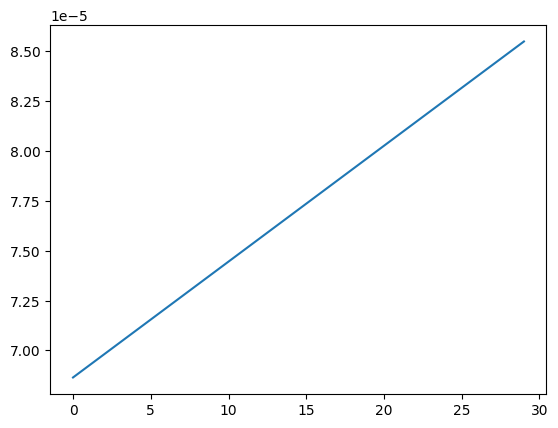

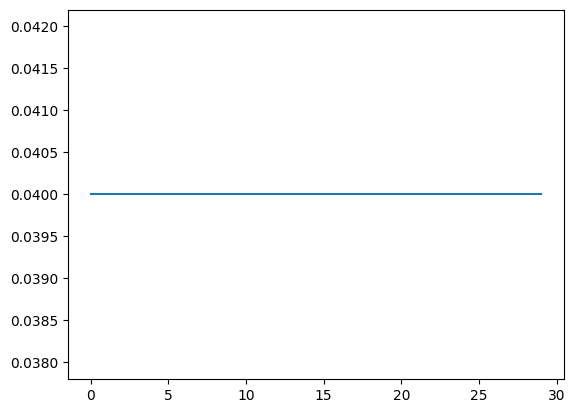

In [68]:
from matplotlib import pyplot as plt
plt.plot(lrs)
plt.show()
plt.plot(wds)
plt.show()

## Warming up

In [ ]:
import gc

In [ ]:
start_epoch = 0
# -- load training checkpoint
if os.path.exists(latest_path):
    (
        encoder,
        predictor,
        target_encoder,
        optimizer,
        scaler,
        start_epoch,
    ) = load_checkpoint(
        r_path=resume_path,
        encoder=encoder,
        predictor=predictor,
        target_encoder=target_encoder,
        opt=optimizer,
        scaler=scaler,
    )
    for _ in range(start_epoch * ipe):
        scheduler.step()
        wd_scheduler.step()

In [ ]:
def save_checkpoint(epoch, path):
    if rank != 0:
        return
    save_dict = {
        "encoder": encoder.state_dict(),
        "predictor": predictor.state_dict(),
        "opt": optimizer.state_dict(),
        "scaler": None if scaler is None else scaler.state_dict(),
        "target_encoder": target_encoder.state_dict(),
        "epoch": epoch,
        "loss": loss_meter.avg,
        "batch_size": batch_size,
        "world_size": world_size,
        "lr": lr,
    }
    try:
        torch.save(save_dict, path)
    except Exception as e:
        logger.info(f"Encountered exception when saving checkpoint: {e}")

In [ ]:
logger.info("Initializing loader...")
unsupervised_sampler.set_epoch(start_epoch)
loader = iter(unsupervised_loader)

if skip_batches > 0:
    logger.info(f"Skip {skip_batches} batches")
    # -- update distributed-data-loader epoch

    for itr in range(skip_batches):
        if itr % 10 == 0:
            logger.info(f"Skip {itr}/{skip_batches} batches")
        try:
            _ = next(loader)
        except Exception:
            loader = iter(unsupervised_loader)
            _ = next(loader)

In [ ]:
if sync_gc:
    gc.disable()
    gc.collect()

In [ ]:
sample = next(loader)

In [ ]:
for key in sample:
    print(key.shape)

## Plot the videousing subplot

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
video = sample[0][0]
# Permute to (1,2,3,0)
video = video.permute(1,2,3,0).cpu().numpy() # Shape (T,H,W,C)
for t in range(video.shape[0]):
    plt.subplot(4, 4, t+1)
    plt.imshow(video[t])
    plt.axis('off')
plt.show()